In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import subprocess

In [2]:
# this is used to set limits on the y-axis for each device separately
y_limit_dictionary = {
    'Tesla-P100' : [0, 100], 
    'Tesla-V100' : [0, 140], 
    'Tesla-A100' : [0, 230], 
    'AMD-EPYC-64' : [0, 175], 
    'AMD-EPYC-24' : [0, 110], 
    'ARM-NEON' : [0, 190], 
    'INTEL-XEON' : [0, 50], 
    'INTEL-ICY' : [0, 70], 
    'IBM-POWER9' : [0, 55], 
    'Alveo-U280' : [0, 30], 
}

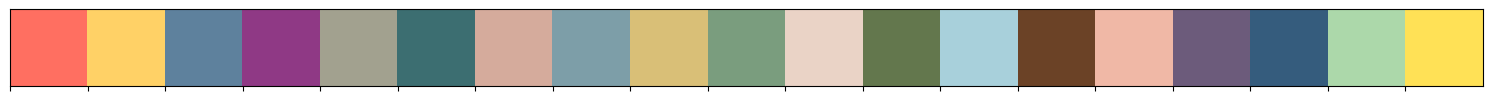

In [3]:
palette = ['#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F','#3C6E71','#D5AB9C','#7D9EA8','#D9BF77','#7A9D7E','#EAD3C6','#63774D','#A8D0DB','#6B4226','#F0B8A6','#6C5B7B','#355C7D','#ACD8AA','#FFE156']
sns.palplot(palette)
plt.show()

In [4]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()


# all devices that will be used
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(1.0, 0.43529411764705883, 0.3803921568627451),
 (1.0, 0.8196078431372549, 0.4),
 (0.3686274509803922, 0.5058823529411764, 0.615686274509804),
 (0.5607843137254902, 0.2235294117647059, 0.5215686274509804),
 (0.6352941176470588, 0.6313725490196078, 0.5607843137254902),
 (0.23529411764705882, 0.43137254901960786, 0.44313725490196076),
 (0.8352941176470589, 0.6705882352941176, 0.611764705882353),
 (0.49019607843137253, 0.6196078431372549, 0.6588235294117647),
 (0.8509803921568627, 0.7490196078431373, 0.4666666666666667),
 (0.47843137254901963, 0.615686274509804, 0.49411764705882355)]

In [5]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [6]:
header_names = ['mtx_name','distribution','placement','seed',
                'm','n','nz','density','A_mem_footprint','mem_range',
                'avg_nz_row','std_nz_row',
                'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                'skew_coeff','avg_num_neighbours','cross_row_similarity',
                'implementation','time','gflops','W_avg','J_estimated', 'System', 'Arch']

# precision = 'f'
precision = 'd' # for double-precision arithmetic

def remove_formats(df, formats_to_discard):
    for ftd in formats_to_discard:
        df = df[df['implementation'] != ftd]
    return df

def print_formats_per_device(df):
    print('------------------------')
    print('Size of dataframe')
    print(df.shape)
    print('Tested formats')
    print(set(df['implementation']))
    print('Tested formats per device:')
    for sys in set(df['System']):
        df_sys = df[df['System'] == sys]
        print(sys, '\t', set(df_sys['implementation']))
    print('------------------------')


---
# Read GPU data

In [7]:
def read_device_data(device, System, Arch, threads = 0):
    if(Arch == 'GPU'):
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_dtype-D_run_friend_dataset.csv', names = header_names)
    elif(Arch == 'CPU'):
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_friends_10_samples_30_range_t%d_%s.csv' % (threads, precision), names = header_names)
    df['System'] = System
    return df

In [8]:
%%time
inputdata_GPU_P100 = read_device_data('vulcan-P100', 'Tesla-P100', 'GPU')
inputdata_GPU_V100 = read_device_data('vulcan-V100', 'Tesla-V100', 'GPU')
inputdata_GPU_A100 = read_device_data('epyc5-A100',  'Tesla-A100', 'GPU')

inputdata_GPU_A100 = inputdata_GPU_A100[inputdata_GPU_A100['gflops']<800] # panastaaaaaaas (some Merge shit is going on here...)

inputdata_GPU = pd.concat([inputdata_GPU_P100, inputdata_GPU_V100, inputdata_GPU_A100])
# inputdata_GPU = pd.concat([inputdata_GPU_A100_friends])
inputdata_GPU['friends'] = True
inputdata_GPU['Arch'] = 'GPU'

# formats to discard here!
formats_to_discard = []
inputdata_GPU = remove_formats(inputdata_GPU, formats_to_discard)

print_formats_per_device(inputdata_GPU)


------------------------
Size of dataframe
(107087, 31)
Tested formats
{'cuSPARSE_csr11', 'SELL-32-1', 'CSR5_9', 'Merge_11', 'cuSPARSE_hyb9-2', 'cuSPARSE_coo11'}
Tested formats per device:
Tesla-A100 	 {'SELL-32-1', 'cuSPARSE_csr11', 'Merge_11', 'cuSPARSE_coo11'}
Tesla-V100 	 {'cuSPARSE_csr11', 'CSR5_9', 'Merge_11', 'cuSPARSE_hyb9-2', 'cuSPARSE_coo11'}
Tesla-P100 	 {'CSR5_9', 'cuSPARSE_coo11', 'cuSPARSE_csr11', 'cuSPARSE_hyb9-2'}
------------------------
CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 1.29 s


---
# Read CPU data

In [9]:
%%time    
# select for CPU which data to read (used later in validation too)
Hawk_threads = 64
Epyc_threads = 24
Xeon_threads = 14
Icy_threads  = 16
Arm_threads = 80
Power9_threads = 32

inputdata_CPU_AMD_HAWK    = read_device_data('amd-hawk',    'AMD-EPYC-64', 'CPU', Hawk_threads)
inputdata_CPU_AMD_EPYC1   = read_device_data('amd-epyc1',   'AMD-EPYC-24', 'CPU', Epyc_threads)
inputdata_CPU_INTEL_GOLD2 = read_device_data('intel-gold2', 'INTEL-XEON',  'CPU', Xeon_threads)
inputdata_CPU_INTEL_ICY3  = read_device_data('intel-icy3',  'INTEL-ICY',   'CPU', Icy_threads)
inputdata_CPU_ARM_NEON    = read_device_data('arm',         'ARM-NEON',    'CPU', Arm_threads)
inputdata_CPU_IBM_POWER9  = read_device_data('power9-m100', 'IBM-POWER9',  'CPU', Power9_threads)

# fix some things...
inputdata_CPU_AMD_EPYC1.astype({'avg_bandwidth': 'float64'})
inputdata_CPU_IBM_POWER9['W_avg'] = 200.1 # We could not measure power consumption from IBM Power9

inputdata_CPU = pd.concat([inputdata_CPU_AMD_HAWK, inputdata_CPU_AMD_EPYC1,
                           inputdata_CPU_ARM_NEON,
                           inputdata_CPU_INTEL_GOLD2, inputdata_CPU_INTEL_ICY3,
                           inputdata_CPU_IBM_POWER9])
inputdata_CPU['Arch'] = 'CPU'    

# formats to discard here!
formats_to_discard = ['Custom_CSR_PBV_x86', 'Custom_CSR_PBV']
inputdata_CPU = remove_formats(inputdata_CPU, formats_to_discard)

print_formats_per_device(inputdata_CPU)

# inputdata_CPU = inputdata_CPU.round({'nz': -1, 'A_mem_footprint': 3, 'density': 3,
#              'avg_nnz_row': 3, 'std_nnz_row': 3,
#              'avg_bandwidth': -1, 'std_bandwidth': -1, 'avg_bandwidth_scaled': 2, 'std_bandwidth_scaled': 2,
#              'avg_scattering': 2, 'std_scattering': 2, 'avg_scattering_scaled': -1, 'std_scattering_scaled': -1,
#              'skew_coeff': 1,
#              'avg_num_neighbours' : 3, 'cross_row_similarity': 3})

------------------------
Size of dataframe
(424472, 30)
Tested formats
{'AOCL_OPTMV', 'MKL_IE', 'Custom_CSR_BV_x86', 'SparseX', 'SELL-32-1', 'Custom_CSR_BV', 'MERGE', 'CSR5', 'ARMPL', 'Naive_CSR_CPU', 'Custom_CSR_B'}
Tested formats per device:
INTEL-XEON 	 {'MKL_IE', 'Custom_CSR_BV_x86', 'SparseX', 'SELL-32-1', 'MERGE', 'CSR5', 'Naive_CSR_CPU'}
AMD-EPYC-24 	 {'AOCL_OPTMV', 'MKL_IE', 'Custom_CSR_BV_x86', 'SparseX', 'SELL-32-1', 'MERGE', 'CSR5', 'Naive_CSR_CPU'}
IBM-POWER9 	 {'SparseX', 'Custom_CSR_BV', 'MERGE', 'Naive_CSR_CPU', 'Custom_CSR_B'}
AMD-EPYC-64 	 {'CSR5', 'Naive_CSR_CPU', 'MKL_IE'}
ARM-NEON 	 {'SparseX', 'SELL-32-1', 'MERGE', 'ARMPL', 'Naive_CSR_CPU'}
INTEL-ICY 	 {'MKL_IE', 'SparseX', 'Custom_CSR_BV', 'SELL-32-1', 'MERGE', 'CSR5', 'Naive_CSR_CPU'}
------------------------
CPU times: user 3.01 s, sys: 0 ns, total: 3.01 s
Wall time: 5.41 s


---
# Read FPGA data

In [10]:
fname = "alveo-u280_spmv_validation_matrices_10_samples_30_range_twins_dtype-D.csv"
inputdata_FPGA = pd.read_csv('../benchmark_results/alveo-u280/%s' % fname, names = header_names)
inputdata_FPGA['System'] = 'Alveo-U280'

inputdata_FPGA['Arch'] = 'FPGA'

print_formats_per_device(inputdata_FPGA)


------------------------
Size of dataframe
(8276, 30)
Tested formats
{'Xilinx_SpMV'}
Tested formats per device:
Alveo-U280 	 {'Xilinx_SpMV'}
------------------------


# Concatenate all data, place in *inputdata* dataframe

In [11]:
# Merge the results
inputdata = pd.concat([inputdata_GPU,inputdata_CPU,inputdata_FPGA])

print(inputdata.shape)

# Group per reps, take mean
groupreps = inputdata.groupby(['mtx_name','distribution','placement','seed',
                               'm','n','nz','density','A_mem_footprint','mem_range',
                               'avg_nz_row','std_nz_row',
                               'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                               'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                               'skew_coeff','avg_num_neighbours','cross_row_similarity',
                               'implementation','System', 'Arch']).mean().reset_index().reindex(columns=header_names)

# dataTypeSeries = groupreps.dtypes
# print('Data type of each column of Dataframe :')
# print(dataTypeSeries)
print(groupreps.shape)
group_system_best = groupreps

(539835, 31)
(141551, 30)


---
# Group by "best-of" implementation for each device
# skip this step if you want to plot every measurement collected

In [12]:
%%time
# Group per system, take best (it was over "inputdata", but "groupreps" is better choice I think)
# fixed this after reordering groupreps columns according to header_names
# before this, columns and data were mixed and it was a complete shitstorm
group_system = groupreps.groupby(['mtx_name','distribution','placement','seed',
                                  'm','n','nz','density','A_mem_footprint','mem_range',
                                  'avg_nz_row','std_nz_row',
                                  'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                                  'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                                  'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                  'System','Arch'], as_index = False)
reslist = []
for desc, experiment in group_system:
    best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['implementation'] == best_format]
    # if(len(outrow)>1):
    #     print(len(outrow), outrow)
    reslist.append(outrow.values.tolist()[0])
    # print(outrow.values.tolist()[0])
group_system_best = pd.DataFrame(reslist, columns = header_names)

print(group_system_best.shape)

(31603, 30)
CPU times: user 30.3 s, sys: 0 ns, total: 30.3 s
Wall time: 30.1 s


---
# wins per format per device (percentage of each format that shows best performance for the matrices in the synthetic dataset)

In [13]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']

for system in ranges_dev:
    print('---', system, '---')
    group_sys = group_system_best[group_system_best['System']==system]
    print(group_sys.shape)
    implementations = set(group_sys['implementation'])
    sys_shape = group_sys.shape[0]
    for impl in implementations:
        group_sys_impl = group_sys[group_sys['implementation']==impl]
        sys_impl_shape = group_sys_impl.shape[0]
        print(np.round(sys_impl_shape/sys_shape*100,2), '%', '\t', impl)
    print('---')

--- Tesla-P100 ---
(1958, 30)
20.48 % 	 cuSPARSE_coo11
31.05 % 	 CSR5_9
29.37 % 	 cuSPARSE_csr11
19.1 % 	 cuSPARSE_hyb9-2
---
--- Tesla-V100 ---
(3261, 30)
72.46 % 	 cuSPARSE_csr11
17.72 % 	 CSR5_9
0.28 % 	 Merge_11
6.01 % 	 cuSPARSE_hyb9-2
3.53 % 	 cuSPARSE_coo11
---
--- Tesla-A100 ---
(3261, 30)
2.18 % 	 SELL-32-1
38.7 % 	 cuSPARSE_coo11
57.71 % 	 cuSPARSE_csr11
1.41 % 	 Merge_11
---
--- AMD-EPYC-24 ---
(3261, 30)
2.09 % 	 AOCL_OPTMV
35.54 % 	 MKL_IE
24.78 % 	 Custom_CSR_BV_x86
18.4 % 	 SparseX
3.86 % 	 SELL-32-1
12.82 % 	 MERGE
2.02 % 	 CSR5
0.49 % 	 Naive_CSR_CPU
---
--- AMD-EPYC-64 ---
(1958, 30)
11.95 % 	 CSR5
0.41 % 	 Naive_CSR_CPU
87.64 % 	 MKL_IE
---
--- ARM-NEON ---
(3261, 30)
1.84 % 	 SELL-32-1
63.81 % 	 ARMPL
28.15 % 	 SparseX
6.19 % 	 MERGE
---
--- INTEL-XEON ---
(3275, 30)
25.68 % 	 MKL_IE
28.03 % 	 Custom_CSR_BV_x86
3.91 % 	 SparseX
16.06 % 	 SELL-32-1
25.1 % 	 MERGE
1.19 % 	 CSR5
0.03 % 	 Naive_CSR_CPU
---
--- INTEL-ICY ---
(3261, 30)
24.29 % 	 MKL_IE
16.34 % 	 SparseX


---
# Validation matrices 

In [14]:
header_names = ['mtx_name','distribution','placement','seed',
                'm','n','nz','density','A_mem_footprint','mem_range',
                'avg_nz_row','std_nz_row',
                'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                # 'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
                'skew_coeff', 'avg_num_neighbours','cross_row_similarity',
                'implementation','time','gflops','W_avg','J_estimated', 'System', 'Arch']

def find_class(mem_footprint):
    low_mb_list =   [4,8, 16,32,64, 128,256,512, 1024,2048, 4096] # removed largest mem range (2048-4096)
    high_mb_list =  [8,16,32,64,128,256,512,1024,2048,4096, 8192]
    for i in range(len(low_mb_list)):
        if(mem_footprint>=low_mb_list[i] and mem_footprint<=high_mb_list[i]):
            pos = i
            mem_range = '['+str(low_mb_list[pos])+'-'+str(high_mb_list[pos])+']'
            return mem_range
    return str(-1)

# first of all, we will generate some "modified_features" csv files, that take as input the existing validation matrix benchmark results

---
# read GPU data

In [15]:
def modify_footprint(v):
    if(v["implementation"]=="CSR5_9"):
        return (v["A_mem_footprint"] - 4*(v["m"]+v["n"]))/(1024*1024.0)
    else:
        return v["A_mem_footprint"]

def create_complete_gpu_csv(gpu_dataframe, system, arch):
    gpu_dataframe["mtx_name"] = gpu_dataframe["mtx_name"].apply(lambda x: x.split("/")[-1].split(".")[0])
    vm_features = pd.read_csv("../benchmark_results/validation_matrices_features.csv", sep="\t")
    mtx_names = list(vm_features["matrix"]) # same as : list(set(inputdata_GPU["mtx_name"]))

    inputvaldata_GPU = pd.DataFrame(columns=header_names)

    for mtx_name in mtx_names:
        for index, curr in gpu_dataframe[gpu_dataframe["mtx_name"] == mtx_name].iterrows():
            mtx_name = mtx_name
            distribution = "unused"
            placement = "unused"
            seed = curr["seed"]
            m = curr["m"]
            n = curr["n"]
            nz = curr["nz"]
            density = nz/(m*n)*100.0
            A_mem_footprint = curr["A_mem_footprint"]
            mem_range = find_class((nz*(64+32)+32*(m+1))/(8*1024*1024))
            avg_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-avg"])[0]
            std_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-std"])[0]
            avg_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0]*n
            std_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-std"])[0]*n
            avg_bandwidth_scaled = avg_bandwidth/n
            std_bandwidth_scaled = std_bandwidth/n
            # avg_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-avg"])[0]
            # std_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-std"])[0]
            # avg_scattering_scaled = avg_scattering*n
            # std_scattering_scaled = std_scattering*n
            # skew_coeff = (list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-max"])[0] - avg_nz_row)/avg_nz_row
            skew_coeff = list(vm_features[vm_features["matrix"]==mtx_name]["skew_coeff"])[0]
            avg_num_neighbours = list(vm_features[vm_features["matrix"]==mtx_name]["num-neigh-avg"])[0]
            cross_row_similarity = list(vm_features[vm_features["matrix"]==mtx_name]["cross_row_sim-avg"])[0]

            implementation = curr["implementation"]
            time = curr["time"]
            gflops = curr["gflops"]
            W_avg = curr["W_avg"]
            J_estimated = curr["J_estimated"]

            new_row = {'mtx_name' : mtx_name, 'distribution' : distribution, 'placement' : placement, 'seed' : seed, 
                       'm' : m, 'n' : n, 'nz' : nz, 'density' : density, 'A_mem_footprint' : A_mem_footprint, 'mem_range' : mem_range, 
                       'avg_nz_row' : avg_nz_row, 'std_nz_row' : std_nz_row, 
                       'avg_bandwidth' : avg_bandwidth, 'std_bandwidth' : std_bandwidth, 'avg_bandwidth_scaled' : avg_bandwidth_scaled, 'std_bandwidth_scaled' : std_bandwidth_scaled,
                       'skew_coeff' : skew_coeff, 'avg_num_neighbours' : avg_num_neighbours, 'cross_row_similarity' : cross_row_similarity,
                       'implementation' : implementation, 'time' : time, 'gflops' : gflops, 'W_avg' : W_avg, 'J_estimated' : J_estimated}
            inputvaldata_GPU = pd.concat([inputvaldata_GPU, pd.DataFrame([new_row])], ignore_index=True)
    inputvaldata_GPU['System'] = system
    inputvaldata_GPU['Arch'] = arch
    if(system=='Tesla-V100'):
        inputvaldata_GPU["A_mem_footprint"] = inputvaldata_GPU.apply(lambda x: modify_footprint(x), axis=1)
    return inputvaldata_GPU

# read P100 data

In [16]:
arch, system = 'GPU', 'Tesla-P100'

fname = "vulcan-P100/vulcan-P100_dtype-D_run_validation_matrices.csv" 
# it has different data layout @@@ panastas @@@
gpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
                                                            'm','n','nz','density','A_mem_footprint','mem_range',
                                                            'avg_nz_row','std_nz_row',
                                                            'avg_bandwidth','std_bandwidth','avg_scattering','std_scattering',
                                                            '1','2','3','4','5','6','7',
                                                            'implementation','time','gflops','W_avg', 'J_estimated'])

gpu_data = create_complete_gpu_csv(gpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')
gpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read V100 data

In [17]:
arch, system = 'GPU', 'Tesla-V100'

# fname = "silver1-TeslaV100_dtype-D_run_validation_matrices.csv"
fname = "vulcan-V100/vulcan-V100_dtype-D_run_validation_matrices.csv"
gpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','diagonal_factor','seed',
                                                            'm','n','nz','density','A_mem_footprint','mem_range',
                                                            'avg_nz_row','std_nz_row',
                                                            'avg_bandwidth','std_bandwidth','avg_scattering','std_scattering',
                                                            'implementation','time','gflops','W_avg', 'J_estimated'])

gpu_data = create_complete_gpu_csv(gpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')
gpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read A100 data

In [18]:
arch, system = 'GPU', 'Tesla-A100'

fname = "epyc5-A100/epyc5-A100_dtype-D_run_validation_matrices.csv"
# it has different data layout @@@ panastas @@@
gpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
                                                            'm','n','nz','density','A_mem_footprint','mem_range',
                                                            'avg_nz_row','std_nz_row',
                                                            'avg_bandwidth','std_bandwidth','avg_scattering','std_scattering',
                                                            '1','2','3','4','5','6','7',
                                                            'implementation','time','gflops','W_avg', 'J_estimated'])

gpu_data = create_complete_gpu_csv(gpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')
gpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read CPU data

In [19]:
def create_complete_cpu_csv(cpu_dataframe, system, arch):
    vm_features = pd.read_csv("../benchmark_results/validation_matrices_features.csv", sep="\t")
    mtx_names = list(vm_features["matrix"]) # same as : list(set(inputdata_GPU["mtx_name"]))

    inputvaldata_CPU = pd.DataFrame(columns=header_names)

    for mtx_name in mtx_names:
        for index, curr in cpu_dataframe[cpu_dataframe["mtx_name"] == mtx_name].iterrows():
            mtx_name = mtx_name
            distribution = "unused"
            placement = "unused"
            diagonal_factor = 0
            seed = 0
            m = curr["m"]
            n = curr["n"]
            nz = curr["nz"]
            density = nz/(m*n)*100.0
            A_mem_footprint = curr["A_mem_footprint"]
            mem_range = find_class((nz*(64+32)+32*(m+1))/(8*1024*1024))
            avg_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-avg"])[0]
            std_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-std"])[0]
            avg_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0]*n
            std_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-std"])[0]*n
            avg_bandwidth_scaled = avg_bandwidth/n
            std_bandwidth_scaled = std_bandwidth/n
            # avg_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-avg"])[0]
            # std_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-std"])[0]
            # avg_scattering_scaled = avg_scattering*n
            # std_scattering_scaled = std_scattering*n
            # skew_coeff = (list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-max"])[0] - avg_nz_row)/avg_nz_row
            skew_coeff = list(vm_features[vm_features["matrix"]==mtx_name]["skew_coeff"])[0]
            avg_num_neighbours = list(vm_features[vm_features["matrix"]==mtx_name]["num-neigh-avg"])[0]
            cross_row_similarity = list(vm_features[vm_features["matrix"]==mtx_name]["cross_row_sim-avg"])[0]

            implementation = curr["implementation"]
            time = curr["time"]
            gflops = curr["gflops"]
            W_avg = curr["W_avg"]
            J_estimated = curr["J_estimated"]
            
            new_row = {'mtx_name' : mtx_name, 'distribution' : distribution, 'placement' : placement, 'seed' : seed,  'm' : m, 'n' : n, 'nz' : nz, 'density' : density, 'A_mem_footprint' : A_mem_footprint, 'mem_range' : mem_range, 
                       'avg_nz_row' : avg_nz_row, 'std_nz_row' : std_nz_row, 
                       'avg_bandwidth' : avg_bandwidth, 'std_bandwidth' : std_bandwidth, 'avg_bandwidth_scaled' : avg_bandwidth_scaled, 'std_bandwidth_scaled' : std_bandwidth_scaled,
                       #'avg_scattering' : avg_scattering, 'std_scattering' : std_scattering, 'avg_scattering_scaled' : avg_scattering_scaled, 'std_scattering_scaled' : std_scattering_scaled,
                       'skew_coeff' : skew_coeff, 'avg_num_neighbours' : avg_num_neighbours, 'cross_row_similarity' : cross_row_similarity,
                       'implementation' : implementation, 'time' : time, 'gflops' : gflops, 'W_avg' : W_avg, 'J_estimated' : J_estimated}
            inputvaldata_CPU = pd.concat([inputvaldata_CPU, pd.DataFrame([new_row])], ignore_index=True)
    inputvaldata_CPU['System'] = system
    inputvaldata_CPU['Arch'] = arch
    return inputvaldata_CPU

# read HAWK data

In [20]:
arch, system = 'CPU', 'AMD-EPYC-64'
fname = "amd-hawk/amd-hawk_validation_matrices_t%d_d.csv" % Hawk_threads

cpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data = create_complete_cpu_csv(cpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

if(fname == "amd-hawk/amd-hawk_validation_matrices_t128_d.csv"):
    formats_to_discard = ['MKL_IE_no_optimize', 'Custom_CSR_BV_CPU', 'Custom_CSR_B_CPU']
    
cpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read EPYC data

In [21]:
arch, system = 'CPU', 'AMD-EPYC-24'
fname = "amd-epyc1/amd-epyc1_validation_matrices_t%d_d.csv" % Epyc_threads

cpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data = create_complete_cpu_csv(cpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

cpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read ARM data

In [22]:
arch, system = 'CPU', 'ARM-NEON'
fname = "arm/arm_validation_matrices_t%d_d.csv" % Arm_threads

cpu_data_arm = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data_arm = create_complete_cpu_csv(cpu_data_arm, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

cpu_data_arm.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read INTEL XEON data

In [23]:
arch, system = 'CPU', 'INTEL-XEON'
fname = "intel-gold2/intel-gold2_validation_matrices_t%d_d.csv" % Xeon_threads

cpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data = create_complete_cpu_csv(cpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

cpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read INTEL ICY data

In [24]:
arch, system = 'CPU', 'INTEL-ICY'
fname = "intel-icy3/intel-icy3_validation_matrices_t%d_d.csv" % Icy_threads

cpu_data = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data = create_complete_cpu_csv(cpu_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

cpu_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# read Power9 data

In [25]:
arch, system = 'CPU', 'IBM-POWER9'
fname = "power9-m100/power9-m100_validation_matrices_t%d_d.csv" % Power9_threads

cpu_data_power9 = pd.read_csv('../benchmark_results/%s' % fname, names = ['mtx_name','distribution','placement','seed',
            'm','n','nz','density','A_mem_footprint','mem_range',
            'avg_nz_row','std_nz_row',
            'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
            'avg_scattering','std_scattering','avg_scattering_scaled','std_scattering_scaled',
            'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity',
            'implementation','time','gflops','W_avg','J_estimated', 'System'])

cpu_data_power9 = create_complete_cpu_csv(cpu_data_power9, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')

cpu_data_power9.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


# Read FPGA Data

In [26]:
def create_complete_fpga_csv(fpga_dataframe, system, arch):
    vm_features = pd.read_csv("../benchmark_results/validation_matrices_features.csv", sep="\t")
    mtx_names = list(vm_features["matrix"]) # same as : list(set(inputdata_GPU["mtx_name"]))

    inputvaldata_FPGA = pd.DataFrame(columns=header_names)

    for mtx_name in mtx_names:
        pin_df = fpga_dataframe[fpga_dataframe["matrix"] == mtx_name]
        if(pin_df.empty):
            m = list(vm_features[vm_features["matrix"]==mtx_name]["nr_rows"])[0]
            n = list(vm_features[vm_features["matrix"]==mtx_name]["nr_cols"])[0]
            nz = list(vm_features[vm_features["matrix"]==mtx_name]["nr_nzeros"])[0]
            A_mem_footprint = (nz*(64+32)+32*(m+1))/(8*1024*1024)
            
            new_row = {'mtx_name' : mtx_name, 'distribution' : "unused", 'placement' : "unused", 'seed' : 0, 'm' : m, 'n' : n, 'nz' : nz, 'density' : nz/(m*n)*100.0, 'A_mem_footprint' : A_mem_footprint, 'mem_range' : find_class((nz*(64+32)+32*(m+1))/(8*1024*1024)),'avg_nz_row' : list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-avg"])[0],'std_nz_row' : list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-std"])[0], 'avg_bandwidth' : list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0]*n,'std_bandwidth' : list(vm_features[vm_features["matrix"]==mtx_name]["bw-std"])[0]*n,'avg_bandwidth_scaled' : list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0],'std_bandwidth_scaled' : list(vm_features[vm_features["matrix"]==mtx_name]["bw-std"])[0],'skew_coeff' : list(vm_features[vm_features["matrix"]==mtx_name]["skew_coeff"])[0],'avg_num_neighbours' : list(vm_features[vm_features["matrix"]==mtx_name]["num-neigh-avg"])[0],'cross_row_similarity' : list(vm_features[vm_features["matrix"]==mtx_name]["cross_row_sim-avg"])[0],'implementation' : 'unused','time' : -1,'gflops' : -1,'W_avg' : -1,'J_estimated' : -1}
            inputvaldata_FPGA = pd.concat([inputvaldata_FPGA, pd.DataFrame([new_row])], ignore_index=True)
            
        for index, curr in pin_df.iterrows():
            mtx_name = mtx_name
            distribution = "unused"
            placement = "unused"
            diagonal_factor = 0
            seed = 0
            m = curr["nr_rows"]
            n = curr["nr_cols"]
            nz = curr["nr_nnz"]
            density = nz/(m*n)*100.0
            # A_mem_footprint = curr["mem_footprint"]
            A_mem_footprint = (nz*(64+32)+32*(m+1))/(8*1024*1024)

            mem_range = find_class((nz*(64+32)+32*(m+1))/(8*1024*1024))
            avg_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-avg"])[0]
            std_nz_row = list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-std"])[0]
            avg_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-avg"])[0]*n
            std_bandwidth = list(vm_features[vm_features["matrix"]==mtx_name]["bw-scaled-std"])[0]*n
            avg_bandwidth_scaled = avg_bandwidth/n
            std_bandwidth_scaled = std_bandwidth/n
            # avg_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-avg"])[0]
            # std_scattering = list(vm_features[vm_features["matrix"]==mtx_name]["sc-std"])[0]
            # avg_scattering_scaled = avg_scattering*n
            # std_scattering_scaled = std_scattering*n
            # skew_coeff = (list(vm_features[vm_features["matrix"]==mtx_name]["nnz-r-max"])[0] - avg_nz_row)/avg_nz_row
            skew_coeff = list(vm_features[vm_features["matrix"]==mtx_name]["skew_coeff"])[0]
            avg_num_neighbours = list(vm_features[vm_features["matrix"]==mtx_name]["num-neigh-avg"])[0]
            cross_row_similarity = list(vm_features[vm_features["matrix"]==mtx_name]["cross_row_sim-avg"])[0]

            implementation = curr["implementation"]
            time = curr["runtime_iter"]
            gflops = curr["gflops"]
            W_avg = curr["W_avg"]
            J_estimated = curr["J_estimated"]

            new_row = {'mtx_name' : mtx_name, 'distribution' : distribution, 'placement' : placement, 'seed' : seed, 
                       'm' : m, 'n' : n, 'nz' : nz, 'density' : density, 'A_mem_footprint' : A_mem_footprint, 'mem_range' : mem_range, 
                       'avg_nz_row' : avg_nz_row, 'std_nz_row' : std_nz_row, 
                       'avg_bandwidth' : avg_bandwidth, 'std_bandwidth' : std_bandwidth, 'avg_bandwidth_scaled' : avg_bandwidth_scaled, 'std_bandwidth_scaled' : std_bandwidth_scaled,
                       #'avg_scattering' : avg_scattering, 'std_scattering' : std_scattering, 'avg_scattering_scaled' : avg_scattering_scaled, 'std_scattering_scaled' : std_scattering_scaled,
                       'skew_coeff' : skew_coeff, 'avg_num_neighbours' : avg_num_neighbours, 'cross_row_similarity' : cross_row_similarity,
                       'implementation' : implementation, 'time' : time, 'gflops' : gflops, 'W_avg' : W_avg, 'J_estimated' : J_estimated}
            inputvaldata_FPGA = pd.concat([inputvaldata_FPGA, pd.DataFrame([new_row])], ignore_index=True)

    inputvaldata_FPGA['System'] = system
    inputvaldata_FPGA['Arch'] = arch
    return inputvaldata_FPGA

In [27]:
arch, system = 'FPGA', 'Alveo-U280'

fname = "alveo-u280/alveo-u280_spmv_validation_matrices_dtype-D.csv"
fpga_data = pd.read_csv('../benchmark_results/%s' % fname, names = ["matrix","nr_rows","nr_cols","nr_nnz","density",
                                                             "mem_footprint","implementation","runtime_iter",
                                                             "gflops","W_avg","J_estimated"])

fpga_data = create_complete_fpga_csv(fpga_data, system, arch)
fname2 = fname.replace('.csv', '_modified_features.csv')
fpga_data.to_csv('../benchmark_results/%s' % fname2, header=False, index=False)


---
# Now, read validation matrices complete dataset!

In [28]:
#Unified read
fname = "vulcan-P100/vulcan-P100_dtype-D_run_validation_matrices_modified_features.csv"
inputvaldata_GPU_P100 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

# fname = "silver1-TeslaV100_dtype-D_run_validation_matrices_modified_features.csv" % dtype
fname = "vulcan-V100/vulcan-V100_dtype-D_run_validation_matrices_modified_features.csv"
inputvaldata_GPU_V100 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

# # fname = "epyc5TeslaA100_dtype-D_run_validation_matrices_modified_features.csv"
fname = "epyc5-A100/epyc5-A100_dtype-D_run_validation_matrices_modified_features.csv"
inputvaldata_GPU_A100 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

#Device P100 V100 A100
#specification 720 980.99 1555.00
#copy 720 825.47 1329.58
#scale 720 826.52 1327.59
#add 720 873.63 1376.84
#triadd 720 872.37 1377.21

inputvaldata_GPU_P100['mem_bw_gbytes_s'] = 464
inputvaldata_GPU_P100['cache_bw_gbytes_s'] = 464

inputvaldata_GPU_V100['mem_bw_gbytes_s'] = 760
inputvaldata_GPU_V100['cache_bw_gbytes_s'] = 760

inputvaldata_GPU_A100['mem_bw_gbytes_s'] = 1350
inputvaldata_GPU_A100['cache_bw_gbytes_s'] = 1350

fname = "amd-hawk/amd-hawk_validation_matrices_t%d_d_modified_features.csv" % Hawk_threads
inputvaldata_CPU_Hawk = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "amd-epyc1/amd-epyc1_validation_matrices_t%d_d_modified_features.csv" % Epyc_threads
inputvaldata_CPU_Epyc1 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "arm/arm_validation_matrices_t%d_d_modified_features.csv" % Arm_threads
inputvaldata_CPU_Arm = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "intel-gold2/intel-gold2_validation_matrices_t%d_d_modified_features.csv" % Xeon_threads
inputvaldata_CPU_Gold2 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "intel-icy3/intel-icy3_validation_matrices_t%d_d_modified_features.csv" % Icy_threads
inputvaldata_CPU_Icy3 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "power9-m100/power9-m100_validation_matrices_t%d_d_modified_features.csv" % Power9_threads
inputvaldata_CPU_Power9 = pd.read_csv('../benchmark_results/%s' % fname, names = header_names,index_col=False)

fname = "alveo-u280/PADDED-alveo-u280_spmv_validation_matrices_dtype-D_modified_features.csv"
inputvaldata_FPGA = pd.read_csv('../benchmark_results/%s' % fname, names = header_names, index_col=False)

inputvaldata_CPU_Hawk['mem_bw_gbytes_s'] = 105
inputvaldata_CPU_Hawk['cache_bw_gbytes_s'] = 878

inputvaldata_CPU_Epyc1['mem_bw_gbytes_s'] = 50 # estimates
inputvaldata_CPU_Epyc1['cache_bw_gbytes_s'] = 700 # estimates

# inputvaldata_CPU_Arm['mem_bw_gbytes_s'] = 102
inputvaldata_CPU_Arm['mem_bw_gbytes_s'] = 122
inputvaldata_CPU_Arm['cache_bw_gbytes_s'] = 820

inputvaldata_CPU_Gold2['mem_bw_gbytes_s'] = 55
inputvaldata_CPU_Gold2['cache_bw_gbytes_s'] = 300

inputvaldata_CPU_Icy3['mem_bw_gbytes_s'] = 75
inputvaldata_CPU_Icy3['cache_bw_gbytes_s'] = 350

inputvaldata_CPU_Power9['mem_bw_gbytes_s'] = 100 # needs to be fixed!!!! 109
inputvaldata_CPU_Power9['cache_bw_gbytes_s'] = 600 # needs to be fixed!!!! 612

inputvaldata_FPGA['mem_bw_gbytes_s'] = 287.5 #  20/32 * 460 = 287.5 GB/s (
inputvaldata_FPGA['cache_bw_gbytes_s'] = 287.5

# Merge results

In [29]:
# Merge the results
inputvaldata = pd.concat([inputvaldata_GPU_P100, inputvaldata_GPU_V100, inputvaldata_GPU_A100,
                          inputvaldata_CPU_Hawk, inputvaldata_CPU_Epyc1, 
                          inputvaldata_CPU_Arm, 
                          inputvaldata_CPU_Gold2, inputvaldata_CPU_Icy3,
                          inputvaldata_CPU_Power9,
                          inputvaldata_FPGA])
print(inputvaldata.shape)

header_names.append('mem_bw_gbytes_s')
header_names.append('cache_bw_gbytes_s')

# Group per reps, take mean
# header_names without 'time','gflops','W_avg','J_estimated'
groupvalreps = inputvaldata.groupby( ['mtx_name','distribution','placement','seed',
                                      'm','n','nz','density','A_mem_footprint','mem_range',
                                      'avg_nz_row','std_nz_row',
                                      'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                                      'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                      'implementation','System', 'Arch', 'mem_bw_gbytes_s','cache_bw_gbytes_s']).mean().reset_index().reindex(columns=header_names)

group_val_system_best = groupvalreps

(8836, 28)


---
# Group by "best-of" implementation for each device
# skip this step if you want to plot per-format validation plots

In [30]:
%%time 
# Group per system, take best
# header_names without 'time','gflops','W_avg','J_estimated', 'implementation'
# Curiously, I have to also remove "A_mem_footprint", because for CSR5 it reports different mem_footprint
# for the same matrix, leading to a different representation in groupby
groupval_system = groupvalreps.groupby(['mtx_name','distribution','placement','seed',
                                        'm','n','nz','density','mem_range',
                                        'avg_nz_row','std_nz_row',
                                        'avg_bandwidth','std_bandwidth','avg_bandwidth_scaled','std_bandwidth_scaled',
                                        'skew_coeff','avg_num_neighbours','cross_row_similarity',
                                        'System','Arch', 'mem_bw_gbytes_s','cache_bw_gbytes_s'], as_index = False)
reslist = []

for desc, experiment in groupval_system:
    best_format = experiment['implementation'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['implementation'] == best_format]
    outrow = outrow[header_names] # reorder column because they are mixed by group-by
    reslist.append(outrow.values.tolist()[0])

group_val_system_best = pd.DataFrame(reslist, columns = header_names)
print(group_val_system_best.shape)

(520, 28)
CPU times: user 956 ms, sys: 0 ns, total: 956 ms
Wall time: 956 ms


# Some fixes that have to be done by hand

In [31]:
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'scircuit') , ['A_mem_footprint']] =  11.626
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mac_econ_fwd500') , ['A_mem_footprint']] =  15.361
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'raefsky3') , ['A_mem_footprint']] =  17.118
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rgg_n_2_17_s0') , ['A_mem_footprint']] =  17.18
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'bbmat') , ['A_mem_footprint']] =  20.424
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'appu') , ['A_mem_footprint']] =  21.261
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'conf5_4-8x8-15') , ['A_mem_footprint']] =  22.125
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mc2depi') , ['A_mem_footprint']] =  26.041
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rma10') , ['A_mem_footprint']] =  27.347
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cop20k_A') , ['A_mem_footprint']] =  30.495
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'thermomech_dK') , ['A_mem_footprint']] =  33.352
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'webbase-1M') , ['A_mem_footprint']] =  39.355
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cant') , ['A_mem_footprint']] =  46.099
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'ASIC_680k') , ['A_mem_footprint']] =  46.914
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'roadNet-TX') , ['A_mem_footprint']] =  49.299
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'pdb1HYS') , ['A_mem_footprint']] =  49.861
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b300_c3') , ['A_mem_footprint']] =  50.669
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Chebyshev4') , ['A_mem_footprint']] =  61.803
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'consph') , ['A_mem_footprint']] =  69.102
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'com-Youtube') , ['A_mem_footprint']] =  72.711
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rajat30') , ['A_mem_footprint']] =  73.128
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'radiation') , ['A_mem_footprint']] =  88.257
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Stanford_Berkeley') , ['A_mem_footprint']] =  89.392
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'shipsec1') , ['A_mem_footprint']] =  89.955
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'PR02R') , ['A_mem_footprint']] =  94.286
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'CurlCurl_2') , ['A_mem_footprint']] =  105.178
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'gupta3') , ['A_mem_footprint']] =  106.762
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mip1') , ['A_mem_footprint']] =  118.732
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rail4284') , ['A_mem_footprint']] =  129.152
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'pwtk') , ['A_mem_footprint']] =  133.977
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'crankseg_2') , ['A_mem_footprint']] =  162.164
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Si41Ge41H72') , ['A_mem_footprint']] =  172.498
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b2383') , ['A_mem_footprint']] =  185.21
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'in-2004') , ['A_mem_footprint']] =  198.876
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Ga41As41H72') , ['A_mem_footprint']] =  212.607
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'eu-2005') , ['A_mem_footprint']] =  223.42
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'wikipedia-20051105') , ['A_mem_footprint']] =  232.293
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'kron_g500-logn18') , ['A_mem_footprint']] =  243.225
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'human_gene1') , ['A_mem_footprint']] =  282.407
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'delaunay_n22') , ['A_mem_footprint']] =  303.999
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'GL7d20') , ['A_mem_footprint']] =  347.583
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'sx-stackoverflow') , ['A_mem_footprint']] =  424.585
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'dgreen') , ['A_mem_footprint']] =  442.43
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mawi_201512012345') , ['A_mem_footprint']] =  506.18
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'ldoor') , ['A_mem_footprint']] =  536.04
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'dielFilterV2real') , ['A_mem_footprint']] =  559.9
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'circuit5M') , ['A_mem_footprint']] =  702.405
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'soc-LiveJournal1') , ['A_mem_footprint']] =  808.063
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'bone010') , ['A_mem_footprint']] =  823.92
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'audikw_1') , ['A_mem_footprint']] =  892.255
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cage15') , ['A_mem_footprint']] =  1154.913
group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'kmer_V2a') , ['A_mem_footprint']] =  1551.419

group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'scircuit') , ['A_mem_footprint']] =  11.63
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'mac_econ_fwd500') , ['A_mem_footprint']] =  15.36
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'raefsky3') , ['A_mem_footprint']] =  17.12
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'rgg_n_2_17_s0') , ['A_mem_footprint']] =  17.18
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'bbmat') , ['A_mem_footprint']] =  20.42
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'appu') , ['A_mem_footprint']] =  21.26
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'conf5_4-8x8-15') , ['A_mem_footprint']] =  22.13
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'mc2depi') , ['A_mem_footprint']] =  26.04
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'rma10') , ['A_mem_footprint']] =  27.35
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'cop20k_A') , ['A_mem_footprint']] =  30.5
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'thermomech_dK') , ['A_mem_footprint']] =  33.35
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'webbase-1M') , ['A_mem_footprint']] =  39.35
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'cant') , ['A_mem_footprint']] =  46.1
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'ASIC_680k') , ['A_mem_footprint']] =  46.91
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'roadNet-TX') , ['A_mem_footprint']] =  49.3
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'pdb1HYS') , ['A_mem_footprint']] =  49.86
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b300_c3') , ['A_mem_footprint']] =  50.67
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'Chebyshev4') , ['A_mem_footprint']] =  61.8
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'consph') , ['A_mem_footprint']] =  69.1
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'com-Youtube') , ['A_mem_footprint']] =  72.71
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'rajat30') , ['A_mem_footprint']] =  73.13
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'radiation') , ['A_mem_footprint']] =  88.26
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'Stanford_Berkeley') , ['A_mem_footprint']] =  89.39
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'shipsec1') , ['A_mem_footprint']] =  89.95
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'PR02R') , ['A_mem_footprint']] =  94.29
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'CurlCurl_2') , ['A_mem_footprint']] =  105.18
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'gupta3') , ['A_mem_footprint']] =  106.76
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'mip1') , ['A_mem_footprint']] =  118.73
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'rail4284') , ['A_mem_footprint']] =  129.15
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'pwtk') , ['A_mem_footprint']] =  133.98
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'crankseg_2') , ['A_mem_footprint']] =  162.16
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'Si41Ge41H72') , ['A_mem_footprint']] =  172.5
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b2383') , ['A_mem_footprint']] =  185.21
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'in-2004') , ['A_mem_footprint']] =  198.88
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'Ga41As41H72') , ['A_mem_footprint']] =  212.61
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'eu-2005') , ['A_mem_footprint']] =  223.42
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'wikipedia-20051105') , ['A_mem_footprint']] =  232.29
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'kron_g500-logn18') , ['A_mem_footprint']] =  243.22
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'human_gene1') , ['A_mem_footprint']] =  282.41
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'delaunay_n22') , ['A_mem_footprint']] =  304
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'GL7d20') , ['A_mem_footprint']] =  347.58
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'sx-stackoverflow') , ['A_mem_footprint']] =  424.58
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'dgreen') , ['A_mem_footprint']] =  442.43
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'mawi_201512012345') , ['A_mem_footprint']] =  506.18
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'ldoor') , ['A_mem_footprint']] =  536.04
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'dielFilterV2real') , ['A_mem_footprint']] =  559.9
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'circuit5M') , ['A_mem_footprint']] =  702.4
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'soc-LiveJournal1') , ['A_mem_footprint']] =  808.06
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'bone010') , ['A_mem_footprint']] =  823.92
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'audikw_1') , ['A_mem_footprint']] =  892.25
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'cage15') , ['A_mem_footprint']] =  1154.91
group_val_system_best.loc[(group_val_system_best['System'] == 'Tesla-V100') &(group_val_system_best['mtx_name'] == 'kmer_V2a') , ['A_mem_footprint']] =  1551.42


# begin plotting
# perhaps figure size needs refinement, you know better

In [32]:
def get_em_feats(pcg, features, dataframe, row, threshold=1):
    low = 1 - pcg*0.01
    high = 1 + pcg*0.01
    first = True
    feature_boolean = True
    for i in range(len(features)):
        feature = features[i]
        feature_boolean_tmp = feature_boolean &\
                              (dataframe[feature] <= row[feature]*high) &\
                              (dataframe[feature] >= row[feature]*low)

        isol = dataframe[feature_boolean_tmp]
        pcg2 = pcg
        # try to find twins only when skew_coeff value is low
        if((feature == 'skew_coeff' and row[feature] < 5) or (feature == 'avg_num_neighbours') or (feature == 'cross_row_similarity')):
            while(isol.shape[0]<threshold):
                pcg2 = pcg2+1
                if((feature == 'avg_num_neighbours' and pcg2>50) or (feature == 'cross_row_similarity' and pcg2>50) or pcg2>1000):
                    break
                low2 = 1 - pcg2*0.01
                high2 = 1 + pcg2*0.01
                feature_boolean_tmp = feature_boolean &\
                                      (dataframe[feature] <= row[feature]*high2) &\
                                      (dataframe[feature] >= row[feature]*low2)
                isol = dataframe[feature_boolean_tmp]

        # if(pcg2!=pcg):
        #     if(feature=='skew_coeff'):
        #         print('\n',feature, '\t\t', pcg,'->', pcg2, '\t', row['mtx_name'],'\t', row[feature])
        #     else:
        #         print('\n',feature, '\t', pcg,'->', pcg2, '\t', row['mtx_name'],'\t', row[feature])
        #     if(feature !='m'):# and feature !='avg_nz_row'):
        #         print(row['mtx_name'], features[i], row[feature], isol.shape)
        #         print(sorted(set([x for x in isol[feature]])))
        #     if(feature !='m'):
        #         if(i<len(features)-1):
        #             print('\t', features[i+1], sorted(set([np.round(x,2) for x in isol[features[i+1]]])), '\n')

        feature_boolean = feature_boolean_tmp

    similar_synthetic = dataframe[feature_boolean]
    return similar_synthetic


# find at least "threshold" twins for each validation matrix
## set threshold = -1 to skip trying 

In [33]:
# threshold = -1
threshold = 10

# Roofline Stuff (maybe not needed)

In [34]:
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'scircuit') , ['nz']] = 11238432
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mac_econ_fwd500') , ['nz']] = 8128608
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'raefsky3') , ['nz']] = 1984768
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'bbmat') , ['nz']] = 3699584
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'conf5_4-8x8-15') , ['nz']] = 5844224
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mc2depi') , ['nz']] = 19709728
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rma10') , ['nz']] = 4365504
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cop20k_A') , ['nz']] = 20706112
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'webbase-1M') , ['nz']] = 67805984
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cant') , ['nz']] = 7189408
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'pdb1HYS') , ['nz']] = 6252896
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b300_c3') , ['nz']] = 7218400
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Chebyshev4') , ['nz']] = 10960160
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'consph') , ['nz']] = 11880576
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'shipsec1') , ['nz']] = 13513344
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'PR02R') , ['nz']] = 19352800
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'mip1') , ['nz']] = 18037152
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rail4284') , ['nz']] = 15567808
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'pwtk') , ['nz']] = 25375072
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'crankseg_2') , ['nz']] = 23444224
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Si41Ge41H72') , ['nz']] = 65859136
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'TSOPF_RS_b2383') , ['nz']] = 18584608
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'in-2004') , ['nz']] = 58338848
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Ga41As41H72') , ['nz']] = 100076224
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'eu-2005') , ['nz']] = 93214656
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'wikipedia-20051105') , ['nz']] = 420560672
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'ldoor') , ['nz']] = 115256640
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'circuit5M') , ['nz']] = 756326272
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'bone010') , ['nz']] = 140701056
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'cage15') , ['nz']] = 1415024096

# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'appu') , ['nz']] = 8084416
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'ASIC_680k') , ['nz']] = 37455808
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'audikw_1') , ['nz']] = 188166272
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'com-Youtube') , ['nz']] = 113827360
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'CurlCurl_2') , ['nz']] = 53630304
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'delaunay_n22') , ['nz']] = 282560384
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'dgreen') , ['nz']] = 293917024
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'dielFilterV2real') , ['nz']] = 218788544
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'gupta3') , ['nz']] = 11407104
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'human_gene1') , ['nz']] = 73413024
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'kron_g500-logn18') , ['nz']] = 177734752
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'radiation') , ['nz']] = 39553824
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'rajat30') , ['nz']] = 54017888
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'roadNet-TX') , ['nz']] = 54095040
# group_val_system_best.loc[(group_val_system_best['System'] == 'Alveo-U280') &(group_val_system_best['mtx_name'] == 'Stanford_Berkeley') , ['nz']] = 31540352


In [35]:
def flops_per_byte_spmv_csr(m,n,nnz,dsize,idxdsize):
    return 2.0 * nnz / (dsize*(m+n+nnz) + idxdsize*(m+1 + nnz)) 

group_val_system_best['flops_per_byte'] = flops_per_byte_spmv_csr(group_val_system_best['m'], group_val_system_best['n'], group_val_system_best['nz'], 8, 4)
group_val_system_best['gflops_cache_roof'] = group_val_system_best['flops_per_byte']*group_val_system_best['cache_bw_gbytes_s']
group_val_system_best['gflops_mem_roof'] = group_val_system_best['flops_per_byte']*group_val_system_best['mem_bw_gbytes_s']
group_val_system_best.loc[(group_val_system_best['gflops'])<=0, ['gflops_mem_roof']] = -10
group_val_system_best.loc[(group_val_system_best['gflops'])<=0, ['gflops_cache_roof']] = -10
# print(group_val_system_best)   

# Plotting time ... 

In [ ]:
%%time
font = 6
ctr = 0
validation_metadata_systems = []
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
change_colors(ranges_dev, color_dictionary)

fig, axs = plt.subplots(len(ranges_dev))
fig.subplots_adjust(left=.12, bottom=.17*(2/5)*(4/3.5), right=.99, top=.94)
for system in ranges_dev:
    plot_x_axis = 'mtx_name'
    plot_y_axis = 'gflops'
    plot_y_axis_memroof = 'gflops_mem_roof'
    plot_y_axis_cacheroof = 'gflops_cache_roof'
    # when you want to plot overall best format
    impl = ''

    # when you want to plot specific format
    # impl = 'cuSPARSE_coo11'
    # impl = 'cuSPARSE_csr11'
    # impl = 'cuSPARSE_hyb9-2'
    # impl = 'CSR5_9'

    select_criterion = ( group_val_system_best['System'] == system )
    select_str = 'Validation-'+system+'\n'+'rows ±30%, avg nonzeros per row ±30%, skew_coeff ±30%,'+'\n' + 'avg_num_neighbours ±30%, cross_row_similarity ±30%'
    if(impl!=''):
        select_criterion =  select_criterion & (group_val_system_best['implementation'] == impl)
        select_str = impl+"_"+ select_str

    groupvalreps_select_best = group_val_system_best[select_criterion]

    groupvalreps_select_sorted = groupvalreps_select_best.sort_values('A_mem_footprint')

    poulo_list = ['rgg_n_2_17_s0', 'appu', 'kron_g500-logn18', 'GL7d20', 'kmer_V2a', 'roadNet-TX', 'CurlCurl_2']
    for mtx_name_poulo in poulo_list:
        groupvalreps_select_sorted = groupvalreps_select_sorted[groupvalreps_select_sorted.mtx_name != mtx_name_poulo]

    group_system_best_part = group_system_best[group_system_best['System'] == system]

    df_empty = True
    # exclude_matrices = [
    #     "wikipedia-20051105","scircuit","mac_econ_fwd500","rail4284","circuit5M","conf5_4-8x8-15","rajat31","in-2004","eu-2005","TSOPF_RS_b300_c3","mip1","PR02R","Ga41As41H72","shipsec1","Si41Ge41H72","crankseg_2","TSOPF_RS_b2383",
    #     "mc2depi","raefsky3","cop20k_A","bbmat","Chebyshev4","rma10","cage15","cant","pdb1HYS","consph","ldoor","pwtk","bone010" #,"webbase-1M"
    # ]  
    # groupvalreps_select_sorted = groupvalreps_select_sorted[~groupvalreps_select_sorted['mtx_name'].isin(exclude_matrices)]

    validation_headers = ['mtx_name', 'val_gflops', 'synth_mean', 'synth_median', 'synth_min', 'synth_max', 'diff_median', 'diff_mean', 'diff_min', 'diff_max', 'diff_MAPE', 'diff_best_friend_APE']
    validation_metadata = pd.DataFrame(columns=validation_headers)
    
    sum_of_MAPES, sum_of_friends = 0, 0
    index_local=1
    for index, row in groupvalreps_select_sorted.iterrows():
        pd.options.mode.chained_assignment = None  # default='warn'
        pcg = 30 # +-30%         
        # features to consider too : 'nz', 'std_nz_row', 'avg_bandwidth_scaled'
        features = ['m', 'avg_nz_row', 'skew_coeff', 'avg_num_neighbours', 'cross_row_similarity']
        similar_synthetic = get_em_feats(pcg, features, group_system_best_part, row, threshold)

        if(impl==''):
            mtx_name_ext = "".join([row['mtx_name']," (",str((row['implementation'])), " - ",str(similar_synthetic.shape[0]), ")"])
        else:
            mtx_name_ext = "".join([row['mtx_name']," (",str(round(row['A_mem_footprint'],1)), " - ",str(similar_synthetic.shape[0]), ")"])
        #similar_synthetic['mtx_name'] = mtx_name_ext Adds Implementation and num of friends in name
        similar_synthetic['mtx_name'] = row['mtx_name']

        # box_stats are only useful for "min" and "max".  (https://www.adamsmith.haus/python/docs/matplotlib.cbook.boxplot_stats)
        # for "mean" and "median", same values as simple queries to dataframe are returned
        box_stats = boxplot_stats(similar_synthetic['gflops'])[0]
        synth_mean = box_stats['mean'] # similar_synthetic['gflops'].mean()
        synth_median = box_stats['med'] # similar_synthetic['gflops'].median()
        # these two are the "whiskers" of the boxplot, excluding outliers from min and max
        synth_min = box_stats['whislo']
        synth_max = box_stats['whishi']

        if(row['gflops']>0):
            diff_mean = (synth_mean - row['gflops'])/row['gflops'] *100
            diff_median = (synth_median - row['gflops'])/row['gflops'] *100
            diff_min = (synth_min - row['gflops'])/row['gflops'] *100
            diff_max = (synth_max - row['gflops'])/row['gflops'] *100
            
            # old MAPE
            # diff_MAPE = abs(synth_mean - row['gflops'])/row['gflops'] *100
            synthetic_gflops = list(similar_synthetic['gflops'])
            summ=0
            for sg in synthetic_gflops:
                summ += abs((row['gflops']-sg)/row['gflops'])
            if(len(synthetic_gflops)>0):
                diff_MAPE = 100*summ/(similar_synthetic.shape[0])
                sum_of_MAPES += 100*summ
                sum_of_friends += similar_synthetic.shape[0]
                # print(row['mtx_name'], similar_synthetic.shape[0])
            else:
                diff_MAPE = 0
            
            diff_best_friend_APE = 10000000
            if(len(synthetic_gflops)>0):
                for index, friend_matrix in similar_synthetic.iterrows():
                    temp_diff_best_friend_APE = abs(friend_matrix['gflops'] - row['gflops'])/row['gflops'] *100
                    if diff_best_friend_APE > temp_diff_best_friend_APE:
                        diff_best_friend_APE = temp_diff_best_friend_APE
            else:
                diff_best_friend_APE = -1
        else:
            diff_mean, diff_median, diff_min, diff_max, diff_MAPE, diff_best_friend_APE = 0,0,0,0,0,0

        val_md =  [row['mtx_name'], row['gflops'], 
                   similar_synthetic['gflops'].mean(), similar_synthetic['gflops'].median(), similar_synthetic['gflops'].min(), similar_synthetic['gflops'].max(), 
                   diff_mean, diff_median, diff_min, diff_max, diff_MAPE, diff_best_friend_APE]

        if similar_synthetic.empty:
            similar_synthetic = pd.DataFrame([[mtx_name_ext] + [0]*(len(group_system_best_part.columns)-1)], columns = group_system_best_part.columns)
            # if no "similar_synthetic" are found, don't plot the real one either (no point, it just destroys your APE numbers and need manual fixing later)
            groupvalreps_select_sorted.loc[(groupvalreps_select_sorted['mtx_name'] == row['mtx_name']), ['gflops_mem_roof']] = -10
            groupvalreps_select_sorted.loc[(groupvalreps_select_sorted['mtx_name'] == row['mtx_name']), ['gflops_cache_roof']] = -10
            groupvalreps_select_sorted.loc[(groupvalreps_select_sorted['mtx_name'] == row['mtx_name']), ['gflops']] = -10
            
        if(row['gflops']<0):
            similar_synthetic = pd.DataFrame([[mtx_name_ext] + [0]*(len(group_system_best_part.columns)-1)], columns = group_system_best_part.columns)
        if df_empty:
            synthetic_neighbors = similar_synthetic
            validation_metadata.loc[0] = val_md
            df_empty = False
        else:
            synthetic_neighbors = pd.concat([synthetic_neighbors, similar_synthetic])
            validation_metadata.loc[len(validation_metadata)] = val_md
    if(sum_of_friends==0):
        device_MAPE = 0
    else:
        device_MAPE = np.round(sum_of_MAPES / sum_of_friends,2)
    print(system,'\t->\t', device_MAPE)
    
    select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')
    sns_plot = sns.boxplot(data=synthetic_neighbors, x='mtx_name', y=plot_y_axis, ax=axs[ctr], fliersize = 0.5, linewidth = 0.5, color = color_dictionary[system], 
                          # showmeans=True,meanprops={"marker":"s","markerfacecolor":"green", "markeredgecolor":"blue","markersize":"2"}
                          )
    sns_plot = sns.scatterplot(data=groupvalreps_select_sorted, x=plot_x_axis, y=plot_y_axis, ax=axs[ctr], s = 10, color = 'k')
    if system == "AMD-EPYC-24" or system == "AMD-EPYC-64" or system == "ARM-NEON" or system == "INTEL-XEON" or system == "INTEL-ICY" or system == 'IBM-POWER9':
        sns_plot_llc = sns.lineplot(data=groupvalreps_select_sorted, x=plot_x_axis, y=plot_y_axis_cacheroof, 
                                ax=axs[ctr], marker='X', markersize = 3, linestyle='', color = 'gray', markeredgewidth=0)
    sns_plot_mem = sns.lineplot(data=groupvalreps_select_sorted, x=plot_x_axis, y=plot_y_axis_memroof, 
                                ax=axs[ctr], marker='^', markersize = 3, linestyle='', color = 'gray', markeredgewidth=0)

    axs[ctr].tick_params(axis='both', which='major', labelsize= font-2)
    axs[ctr].tick_params(axis='both', which='minor', labelsize= font-2)
    axs[ctr].set_xticklabels([])
    if ctr == len(ranges_dev)//2:
        axs[ctr].set_ylabel('GFLOPs', fontsize = font-1)
    else:
        axs[ctr].set_ylabel('')
    if ctr == len(ranges_dev) - 1:
        axs[ctr].set_xlabel('Matrix Id (Table III)', fontsize = font-1)
        axs[ctr].set_xticklabels(xtick_labels, fontsize = font-2, rotation = 90)
        axs[ctr].set_ylim([0, axs[ctr].get_ylim()[1]*1.2])
    else:
        axs[ctr].set_xlabel('')
        xtick_labels = range(1,len(set(synthetic_neighbors['mtx_name']))+1)
        axs[ctr].set_xticks([])
        axs[ctr].set_xticklabels([])
        axs[ctr].set_ylim([0, axs[ctr].get_ylim()[1]*1.2])
        
    axs[ctr].text( 0.04, 0.85, ranges_dev[ctr], fontsize=font-1, transform = axs[ctr].transAxes, )

    validation_metadata_systems.append(validation_metadata)
    ctr+=1
    plt.xticks(rotation=90)

plt.subplots_adjust(wspace=0, hspace=0)


# Legendary stuff
import matplotlib.lines as mlines
mem_roof = mlines.Line2D([], [], color='gray', marker='^', markersize=3, linestyle = '--', linewidth = 0.4, label='Roofline Memory')
llc_roof = mlines.Line2D([], [], color='gray', marker='X', markersize=3, linestyle = '--', linewidth = 0.4, label='Roofline LLC')
axs[0].legend(handles=[mem_roof, llc_roof], bbox_to_anchor=(0., 1.0, 1., .102), loc=3, fontsize=6, ncol=2, mode="expand", borderaxespad=0., frameon=False)


In [ ]:
# for ratio in [0.8, 0.9, 1, 1.1, 1.2]:
for ratio in [1.2]:
    fig.set_size_inches(1.2*width, 2*height/(2/5)*ratio*len(ranges_dev)/9)
    plt.tight_layout()
    fig_name = './Plots/%s_%s_devices_Validation_merged-all_x-%s_y-%s.pdf' % (ratio, len(ranges_dev), plot_x_axis, plot_y_axis)
    fig.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


# Print errors (MAPE and best-friend-APE)

# "validation_metadata_systems"  is a list of metadata for each system containing a dataframe with following columns
# ['mtx_name', 'val_gflops', 'synth_mean', 'synth_median', 'synth_min', 'synth_max', 'diff_median', 'diff_mean', 'diff_min', 'diff_max']

In [ ]:
def keep_good_stuff(which_column, validation_metadata_systems):
    # tmp_validation_metadata_df = pd.DataFrame(columns=validation_headers)
    # testing = 'diff_median_'
    testing = ''
    for i in range(len(ranges_dev)):
        validation_metadata_systems_new = validation_metadata_systems[i].rename(columns={which_column:ranges_dev[i]}, inplace=False)
        if(i==0):
            tmp_validation_metadata_df = validation_metadata_systems_new # validation_metadata_systems[i]
        else:
            # validation_metadata_df = pd.concat([validation_metadata_df,validation_metadata_systems[i]], axis=1)
            # https://datacarpentry.org/python-socialsci/11-joins/index.html
            # tmp_validation_metadata_df = pd.merge(tmp_validation_metadata_df,validation_metadata_systems_backup[i], how='left', on = 'mtx_name')
            #/tmp/ipykernel_24490/4187708563.py:13: FutureWarning: Passing 'suffixes' which cause duplicate columns {'val_gflops_x', 'diff_max_x', 'synth_mean_x', 'diff_median_x', 'synth_max_x', 'diff_mean_x', 'diff_min_x', 'synth_min_x', 'synth_median_x'} in the result is deprecated and will raise a MergeError in a future version.
            # tmp_validation_metadata_df = pd.merge(tmp_validation_metadata_df,validation_metadata_systems[i], how='left', on = 'mtx_name') 
            tmp_validation_metadata_df = pd.merge(tmp_validation_metadata_df, 
                                                  validation_metadata_systems_new[[ranges_dev[i]]], 
                                                  left_index=True, right_index=True, how='outer')
    validation_metadata_df = tmp_validation_metadata_df[['mtx_name'] + [i for i in ranges_dev]]
    return validation_metadata_df

# keep only "diff_median" columns
# whichever column is selected, will be the only one printed afterwards
which_column = 'diff_MAPE'
validation_metadata_df = keep_good_stuff(which_column, validation_metadata_systems)
print(validation_metadata_df.columns)
display(validation_metadata_df)
validation_metadata_df.to_csv("%s_validation_vs_friends_MAPE.csv" % len(ranges_dev), sep ='\t')

for i in range(len(ranges_dev)):
    print(ranges_dev[i], round(validation_metadata_df[ranges_dev[i]].sum() / (validation_metadata_df[ranges_dev[i]]!=0).sum(),2))


In [ ]:
which_column = 'diff_best_friend_APE'
validation_metadata_df = keep_good_stuff(which_column, validation_metadata_systems)
print(validation_metadata_df.columns)
display(validation_metadata_df)
validation_metadata_df.to_csv("%s_validation_vs_best_friend_APE.csv" % len(ranges_dev), sep ='\t')

for i in range(len(ranges_dev)):
    print(ranges_dev[i], round(validation_metadata_df[ranges_dev[i]].sum() / (validation_metadata_df[ranges_dev[i]]!=0).sum(),2))


# For ARCS plots

In [ ]:
# print('validation')
# print('system','\t\t','max','\t','median')
# # group_val_system_best
# for system in set(group_val_system_best['System']):
#     group_val_system_best_select = group_val_system_best[group_val_system_best['System'] == system]
#     print(system, '\t', round(group_val_system_best_select['gflops'].max(),0), '\t', round(group_val_system_best_select['gflops'].median(),0))

# print('---')    

# # group_system_best
# print('friends')
# print('system','\t\t','max','\t','median')
# for system in set(group_system_best['System']):
#     group_system_best_select = group_system_best[group_system_best['System'] == system]
#     print(system, '\t', round(group_system_best_select['gflops'].max(),-1), '\t', round(group_system_best_select['gflops'].median(),-1))


# Percentage of optimal performance achieved
# It is extracted as if the total memory footprint of y=A * x is the only memory traffic that needs to happen for CPU->GPU.

In [60]:
def print_opt_perf_pcg(df_start, system):
    print(system)
    df = df_start[(df_start['System'] == system) & (df_start['gflops']>0)]
    df['opt_perf_pcg'] = np.round(df['gflops'] / df['gflops_mem_roof'] * 100,2)
    df = df[['mtx_name', 'gflops_mem_roof', 'gflops', 'implementation', 'opt_perf_pcg']].sort_values('opt_perf_pcg')
    pd.set_option('display.max_rows', len(df))
    display(df)
    pd.reset_option('display.max_rows')
    
print_opt_perf_pcg(group_val_system_best, 'Tesla-A100')
print_opt_perf_pcg(group_val_system_best, 'Tesla-V100')
print_opt_perf_pcg(group_val_system_best, 'Tesla-P100')


Tesla-A100


,mtx_name,gflops_mem_roof,gflops,implementation,opt_perf_pcg
420,rgg_n_2_17_s0,173.108449,54.49894,Merge_11,31.48
107,appu,222.202105,80.15162,cuSPARSE_coo11,36.07
457,scircuit,173.450339,83.42888,cuSPARSE_coo11,48.10
486,sx-stackoverflow,200.949234,107.68040,cuSPARSE_csr11,53.59
127,bbmat,217.087835,117.78580,cuSPARSE_coo11,54.26
207,cop20k_A,208.920042,114.51420,cuSPARSE_coo11,54.81
36,GL7d20,206.287443,114.07660,cuSPARSE_csr11,55.30
387,radiation,214.554432,119.79360,cuSPARSE_csr11,55.83
437,rma10,217.837368,122.72820,cuSPARSE_coo11,56.34
397,raefsky3,219.783763,124.41680,SELL-32-1,56.61


Tesla-V100


,mtx_name,gflops_mem_roof,gflops,implementation,opt_perf_pcg
488,sx-stackoverflow,113.126976,28.02798,cuSPARSE_csr11,24.78
38,GL7d20,116.132190,35.64706,cuSPARSE_csr11,30.70
518,wikipedia-20051105,111.311054,42.01332,cuSPARSE_coo11,37.74
459,scircuit,97.646117,44.71658,CSR5_9,45.79
421,rgg_n_2_17_s0,97.453645,45.88766,cuSPARSE_coo11,47.09
329,mac_econ_fwd500,99.715831,50.27112,CSR5_9,50.41
109,appu,125.091556,70.13354,cuSPARSE_csr11,56.07
409,rail4284,118.915207,73.56100,CSR5_9,61.86
189,conf5_4-8x8-15,121.475390,77.08670,cuSPARSE_csr11,63.46
509,webbase-1M,82.428850,53.00442,CSR5_9,64.30


Tesla-P100


,mtx_name,gflops_mem_roof,gflops,implementation,opt_perf_pcg
517,wikipedia-20051105,67.958328,17.10846,cuSPARSE_coo11,25.17
408,rail4284,72.600863,37.42406,CSR5_9,51.55
458,scircuit,59.615524,30.77926,CSR5_9,51.63
328,mac_econ_fwd500,60.879139,34.19014,CSR5_9,56.16
208,cop20k_A,71.806592,40.93464,cuSPARSE_coo11,57.01
167,circuit5M,66.918657,39.83148,cuSPARSE_coo11,59.52
147,cage15,71.169515,42.98008,cuSPARSE_coo11,60.39
508,webbase-1M,50.324982,31.22332,cuSPARSE_coo11,62.04
18,Chebyshev4,75.734427,47.31216,cuSPARSE_coo11,62.47
128,bbmat,74.613893,49.59682,cuSPARSE_csr11,66.47
